In [2]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader

%matplotlib inline

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 10

/home/minhquana/anaconda3/envs/mldl/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
df_nn = pd.read_csv("../data/processed/data.csv")
print(df_nn.shape)
df_nn.head()

(231455, 11)


,price,abtest,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,age
0,1500,1,4,1,4.875925,117,5.199338,0,37,0,6.149566
1,3600,1,4,1,4.772376,102,-0.892038,2,31,0,4.998967
2,650,1,6,1,5.262694,11,5.199338,0,2,1,6.974538
3,2200,1,2,1,5.347183,8,5.199338,0,25,0,5.687053
4,2000,0,6,1,5.299549,10,5.199338,0,19,0,5.687053


In [5]:
DEVICE

device(type='cpu')

In [6]:
X, y = df_nn.drop("price", axis=1).values, df_nn["price"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8235, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((162012, 10), (34724, 10), (34719, 10))

In [7]:
class CustomDataset:
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

train_dataset = CustomDataset(X_train_scaled, y_train)
val_dataset = CustomDataset(X_val_scaled, y_val)
test_dataset = CustomDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Optuna tuning for Neural Network structure and hyperparameters

In [8]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
    in_features = X_train.shape[1]
    for i in range(n_layers):
        out_features = trial.suggest_int(f"n_units_l{i}", 16, 256)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(out_features))
        layers.append(nn.Dropout(trial.suggest_float(f"dropout_l{i}", 0.1, 0.5)))
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    return nn.Sequential(*layers)

In [9]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    patience = trial.suggest_int("patience", 3, 10)

    model = define_model(trial).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                break

        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_loss

In [10]:
study = optuna.create_study(
    direction="minimize",
    study_name="pytorch_tuning_accelerated",
    load_if_exists=True,
    pruner=optuna.pruners.HyperbandPruner(min_resource=1, max_resource=EPOCHS, reduction_factor=3),
    sampler=optuna.samplers.TPESampler(seed=42),
)

study.optimize(objective, n_trials=30, show_progress_bar=True, n_jobs=-1)

best_trial = study.best_trial
print(f"Best trial: {best_trial.number}")
print(f"Best validation loss: {best_trial.value}")
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-20 03:35:35,640] A new study created in memory with name: pytorch_tuning_accelerated


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-03-20 03:36:59,880] Trial 5 pruned. 
[I 2025-03-20 03:37:00,505] Trial 11 pruned. 
[I 2025-03-20 03:38:06,275] Trial 9 pruned. 
[I 2025-03-20 03:39:39,446] Trial 14 pruned. 
[I 2025-03-20 03:40:40,373] Trial 0 pruned. 
[I 2025-03-20 03:42:14,439] Trial 16 pruned. 
[I 2025-03-20 03:42:15,119] Trial 15 pruned. 
[I 2025-03-20 03:42:23,080] Trial 10 finished with value: 2165789414.5 and parameters: {'learning_rate': 0.06716097295532937, 'weight_decay': 4.299057659490618e-05, 'patience': 3, 'n_layers': 1, 'n_units_l0': 51, 'dropout_l0': 0.39063884012863914}. Best is trial 10 with value: 2165789414.5.
[I 2025-03-20 03:44:29,977] Trial 19 pruned. 
[I 2025-03-20 03:45:51,614] Trial 3 finished with value: 2041377169.5 and parameters: {'learning_rate': 0.009065388335688837, 'weight_decay': 0.009284638465692559, 'patience': 4, 'n_layers': 2, 'n_units_l0': 47, 'dropout_l0': 0.4695223453363965, 'n_units_l1': 174, 'dropout_l1': 0.3366652094071077}. Best is trial 3 with value: 2041377169.5.
[

In [11]:
best_trial.params

{'learning_rate': 0.01627561528101398,
 'weight_decay': 0.0003212213445045219,
 'patience': 5,
 'n_layers': 3,
 'n_units_l0': 143,
 'dropout_l0': 0.3030730839654273,
 'n_units_l1': 187,
 'dropout_l1': 0.21464288674204812,
 'n_units_l2': 93,
 'dropout_l2': 0.23125552414468295}

In [12]:
best_lr = best_trial.params["learning_rate"]
best_wd = best_trial.params["weight_decay"]
best_patience = best_trial.params["patience"]
n_units_l0 = best_trial.params["n_units_l0"]
n_units_l1 = best_trial.params["n_units_l1"]
n_units_l2 = best_trial.params["n_units_l2"]
dropout_l0 = best_trial.params["dropout_l0"]
dropout_l1 = best_trial.params["dropout_l1"]
dropout_l2 = best_trial.params["dropout_l2"]

# Define the Neural Network structure and hyperparameters to be tuned using Optuna.

In [ ]:
class CarPriceNet(nn.Module):
    def __init__(self, input_dim=X_train.shape[1]):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, n_units_l0), nn.ReLU(), nn.BatchNorm1d(n_units_l0), nn.Dropout(dropout_l0)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(n_units_l0, n_units_l1), nn.ReLU(), nn.BatchNorm1d(n_units_l1), nn.Dropout(dropout_l1)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(n_units_l1, n_units_l2), nn.ReLU(), nn.BatchNorm1d(n_units_l2), nn.Dropout(dropout_l2)
        )

        self.output = nn.Linear(n_units_l2, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

In [14]:
model = CarPriceNet().to(DEVICE)
model

CarPriceNet(
  (layer1): Sequential(
    (0): Linear(in_features=10, out_features=143, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(143, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3030730839654273, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=143, out_features=187, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(187, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.21464288674204812, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=187, out_features=93, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(93, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.23125552414468295, inplace=False)
  )
  (output): Linear(in_features=93, out_features=1, bias=True)
)

In [15]:
class EarlyStopping:
    def __init__(self, patience=best_patience, delta=1e-4, filepath="../models/checkpoint.pt", verbose=True):
        self.patience = patience
        self.delta = delta
        self.filepath = filepath
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf

    def __call__(self, loss, model):
        if loss < self.best_loss + self.delta:
            if self.verbose:
                print(f"Loss decreased {self.best_loss} -> {loss}.")
            self.best_loss = loss
            self.counter = 0
            torch.save(model.state_dict(), self.filepath)
            print(f"Model improved. Saving model to {self.filepath}.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Loss did not decrease. Counter: {self.counter}.")
            if self.counter >= self.patience:
                print(f"Stopping early. Best loss: {self.best_loss}.")
                return True
        return False

# Train

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    early_stopping,
    device,
    num_epochs=200,
    print_every=10,
):
    """
    Huấn luyện mô hình neural network với scheduler
    """
    model.to(device)

    history = {"train_losses": [], "val_losses": [], "learning_rates": [], "best_epoch": 0}

    best_epoch = 0
    previous_best_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        history["train_losses"].append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)

                val_loss += loss.item() * X_batch.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        history["val_losses"].append(val_loss)

        current_lr = optimizer.param_groups[0]["lr"]
        history["learning_rates"].append(current_lr)

        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(
                f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f} - LR: {current_lr:.8f}"
            )

        scheduler.step(val_loss)

        previous_best_loss = early_stopping.best_loss

        stop_early = early_stopping(val_loss, model)

        if early_stopping.best_loss < previous_best_loss:
            best_epoch = epoch
            print(f"Update best_epoch: {epoch + 1}")

        if stop_early:
            print(f"Early stop at epoch {epoch + 1}")
            break

    history["best_epoch"] = best_epoch
    print(f"Train completed. Best epoch: {best_epoch + 1}")

    return history

# Eval

In [17]:
def evaluate_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()

    predictions = []
    actuals = []
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Dự đoán
            y_pred = model(X_batch)

            # Tính loss
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item() * X_batch.size(0)

            # Save predictions and actuals
            predictions.extend(y_pred.cpu().numpy().flatten())
            actuals.extend(y_batch.cpu().numpy().flatten())

    test_loss = test_loss / len(test_loader.dataset)

    # Metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    metrics = {"test_loss": test_loss, "mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

    return metrics, predictions, actuals

In [28]:
def visualize_results(history, predictions, actuals):
    plot_data = pd.DataFrame({"Prediction": predictions, "Actual": actuals})

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_losses"], label="Train Loss")
    plt.plot(history["val_losses"], label="Validation Loss")
    plt.axvline(x=history["best_epoch"], color="r", linestyle="--", label=f'Best Epoch: {history["best_epoch"] + 1}')
    plt.title("Training and Validation Loss (MSE)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Actual vs Prediction scatter plot
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x="Actual",
        y="Prediction",
        data=plot_data,
        scatter_kws={"color": "green", "alpha": 0.5},
        line_kws={"color": "red"},
    )
    plt.xlabel("Actual")
    plt.ylabel("Prediction")
    plt.title("Comparison of Actual and Predicted Prices")
    plt.grid(True)
    plt.legend(["Actual", "Prediction"])
    plt.show()

    # Kde plot of predictions and actuals
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=plot_data, x="Prediction", fill=True, common_norm=False, alpha=0.5, label="Prediction")
    sns.kdeplot(data=plot_data, x="Actual", fill=True, common_norm=False, alpha=0.5, label="Actual")
    plt.title("KDE Plot of Predictions vs Actual Values")
    plt.grid(True)
    plt.show()

    # learning rate decay plot
    plt.figure(figsize=(10, 4))
    plt.plot(history["learning_rates"])
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.yscale("log")
    plt.grid(True)
    plt.show()

In [19]:
model = CarPriceNet(input_dim=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5, verbose=True)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=10, filepath="../models/neural_net.pt")

/home/minhquana/anaconda3/envs/mldl/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    early_stopping=early_stopping,
    device=DEVICE,
    num_epochs=200,
    print_every=10,
)

Epoch 1/200 - Train Loss: 7982976.596962 - Val Loss: 3725221.543831 - LR: 0.01627562
Loss decreased inf -> 3725221.543831356.
Model improved. Saving model to ../models/neural_net.pt.
Cập nhật best_epoch thành 1
Loss decreased 3725221.543831356 -> 3592695.8144223015.
Model improved. Saving model to ../models/neural_net.pt.
Cập nhật best_epoch thành 2
Loss decreased 3592695.8144223015 -> 3489086.24628499.
Model improved. Saving model to ../models/neural_net.pt.
Cập nhật best_epoch thành 3
Loss decreased 3489086.24628499 -> 3440576.946895519.
Model improved. Saving model to ../models/neural_net.pt.
Cập nhật best_epoch thành 4
Loss decreased 3440576.946895519 -> 3342424.32167953.
Model improved. Saving model to ../models/neural_net.pt.
Cập nhật best_epoch thành 5
Loss decreased 3342424.32167953 -> 3319472.3485773527.
Model improved. Saving model to ../models/neural_net.pt.
Cập nhật best_epoch thành 6
Loss decreased 3319472.3485773527 -> 3267539.2402373.
Model improved. Saving model to ../m

In [22]:
model.load_state_dict(torch.load("../models/neural_net.pt"))

metrics, predictions, actuals = evaluate_model(model=model, test_loader=test_loader, criterion=criterion, device=DEVICE)

Test Loss: 2864158.778572
MSE: 2864158.500000
RMSE: 1692.382446
MAE: 1133.183350
R²: 0.870706


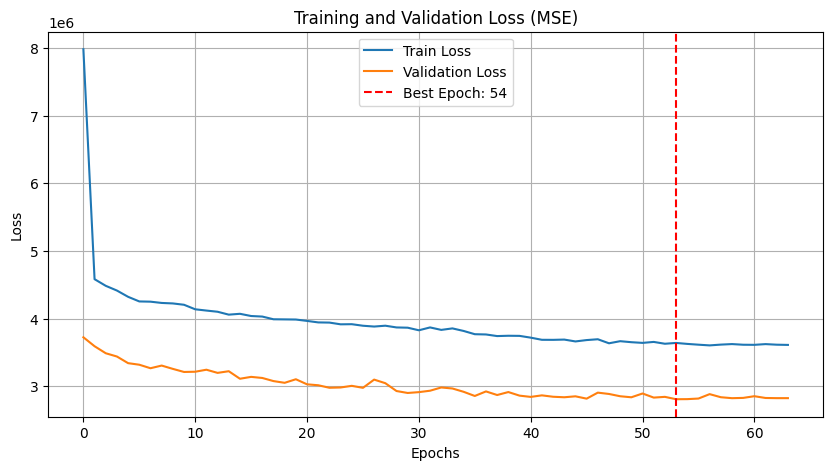

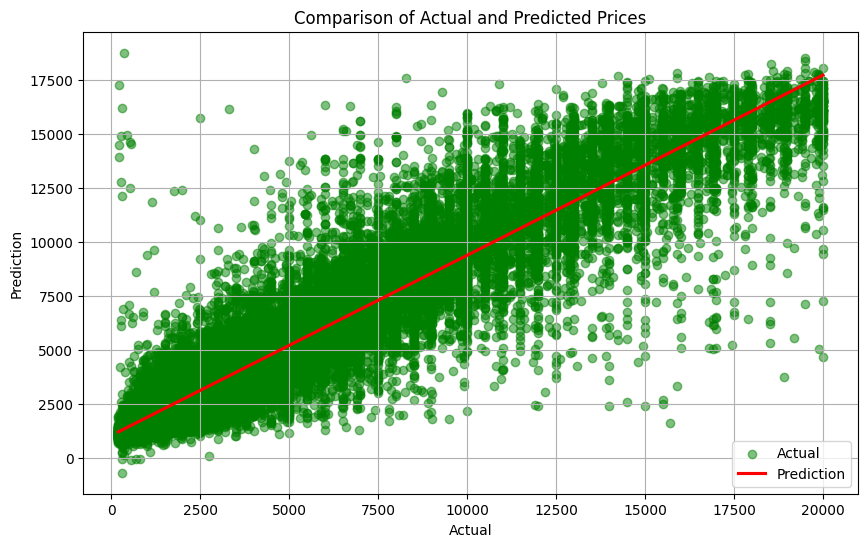

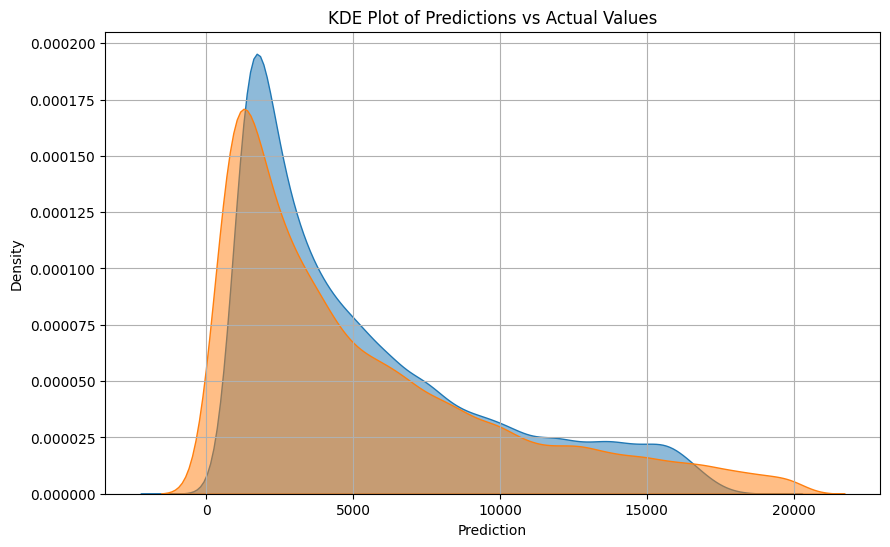

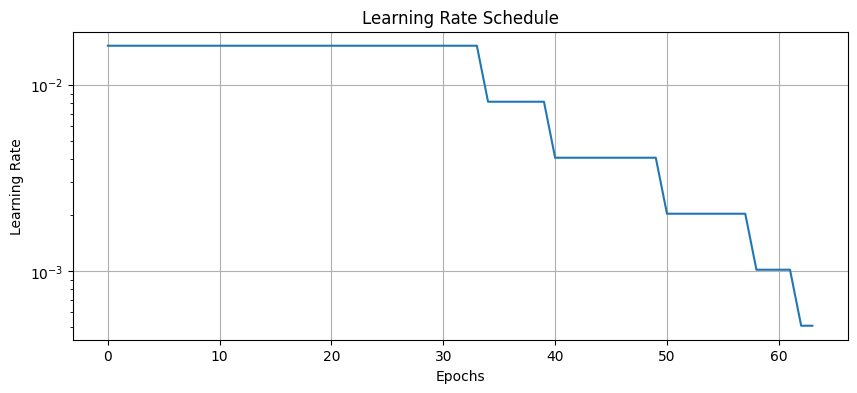

In [29]:
print(f"Test Loss: {metrics['test_loss']:.6f}")
print(f"MSE: {metrics['mse']:.6f}")
print(f"RMSE: {metrics['rmse']:.6f}")
print(f"MAE: {metrics['mae']:.6f}")
print(f"R²: {metrics['r2']:.6f}")

visualize_results(history, predictions, actuals)